In [68]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.decomposition import PCA

In [69]:
warnings.filterwarnings('ignore')

In [121]:
raw_data = pd.read_csv("./data/dataset.csv")
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [122]:
raw_data.head(4)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0


In [123]:
# Checking for duplicates
raw_data.duplicated().sum()

np.int64(0)

In [124]:
# Checking for missing data
raw_data.isna().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [125]:
y = raw_data.stroke
data = raw_data.drop(columns=["stroke", "id"]).copy()

In [126]:
y.value_counts()

stroke
0    42617
1      783
Name: count, dtype: int64

In [127]:
object_columns = list(data.select_dtypes('object').columns)
numerical_columns = list(
    data.columns[~data.columns.isin(object_columns)]
)

print('object_columns', object_columns)
print('numerical_columns', numerical_columns)

object_columns ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_columns ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']


In [54]:
for col in object_columns:
    print(data[col].value_counts(), "\n\n")

gender
Female    25665
Male      17724
Other        11
Name: count, dtype: int64 


ever_married
Yes    27938
No     15462
Name: count, dtype: int64 


work_type
Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: count, dtype: int64 


Residence_type
Urban    21756
Rural    21644
Name: count, dtype: int64 


smoking_status
never smoked       16053
formerly smoked     7493
smokes              6562
Name: count, dtype: int64 




## WorkFlow

**Preprocessing**

- Drop duplicates
- Impute numerical variables with median
- Impute categorical variables with the mode or "most frequent"
    - Impute "smoking_status" with "unknown" --> Due to the large number of missing values.
- Scale numerical variables
- OneHotEncode categorical variables

**Modelling**

- Apply PCA
    - Visualize data in reduced space
- Reconstruct Data
    - Calculate Information loss
    - Define threshold and find anomalies.


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [128]:
def fit_transform(data):
    data = data.copy()

    data.drop_duplicates()

    data["smoking_status"] = data["smoking_status"].fillna("Unknown")

    num_pipe = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler()),
        ]
    )

    cat_pipe = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("scale", OneHotEncoder()),
        ]
    )

    pipe = ColumnTransformer(
        [
            ("num", num_pipe, numerical_columns),
            ("cat", cat_pipe, object_columns),
        ],
        remainder="passthrough"
    )
    # drop
    data = pipe.fit_transform(data)
    return data, pipe

In [ ]:
normal_data = data[y==0]
anomaly_data = data[y==1]

In [141]:
processed_normal_data, pipe = fit_transform(normal_data)
processed_normal_data = pd.DataFrame(
    processed_normal_data,
    index=normal_data.index
)

processed_anomaly_data = pd.DataFrame(
    pipe.transform(anomaly_data),
    index=anomaly_data.index
)
print(processed_normal_data.shape, processed_anomaly_data.shape)

(42617, 21) (783, 21)


### Principal Component Analysis

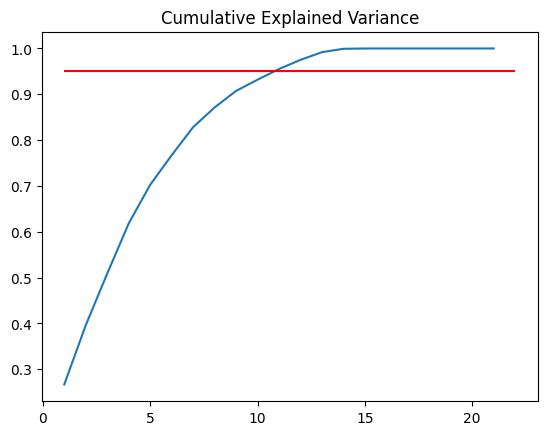

In [147]:
pca0 = PCA(random_state=30)

pca0.fit(processed_normal_data)
components = range(1, processed_normal_data.shape[1] + 1)

plt.figure()
plt.plot(
    components,
    pca0.explained_variance_ratio_.cumsum()
)
plt.hlines(0.95, 1, processed_normal_data.shape[1] + 1, 'r')
plt.title("Cumulative Explained Variance")
plt.show()

pca_normal_data.shape=(42617, 11)


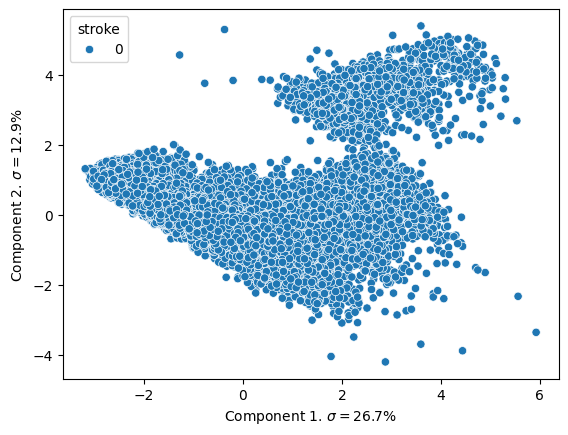

In [ ]:
### Keeping 95% variance

pca = PCA(0.95, random_state=30)

pca_normal_data = pd.DataFrame(pca.fit_transform(processed_normal_data), index=processed_normal_data.index)

print(f"{pca_normal_data.shape=}")

plt.figure()
sns.scatterplot(x=pca_normal_data[0],
                y=pca_normal_data[1])
plt.xlabel(f"Component 1. $\sigma=${pca.explained_variance_ratio_[0]:.1%}")
plt.ylabel(f"Component 2. $\sigma=${pca.explained_variance_ratio_[1]:.1%}")
plt.show()

In [ ]:
# Transforming anomalies to reduced dimension
pca_anomalies = pd.DataFrame(pca.transform(
    processed_anomaly_data), index=processed_anomaly_data.index)

In [163]:
### Reconstructing the data
restored_normal = pd.DataFrame(
    pca.inverse_transform(pca_normal_data), index=pca_normal_data.index)
restored_anomalies = pd.DataFrame(pca.inverse_transform(
    pca_anomalies), index=pca_anomalies.index)
print(f"{restored_anomalies.shape=}")

restored_anomalies.shape=(783, 21)


In [161]:
def information_loss_metric(original_data, transformed_data):
    loss = np.sum(
        (np.array(original_data) - np.array(transformed_data))**2,
        axis=1
    )
    loss = pd.Series(data=loss, index=original_data.index)
    return loss

In [164]:
normal_scores = information_loss_metric(processed_normal_data, restored_normal)
anomaly_scores = information_loss_metric(processed_anomaly_data, restored_anomalies)
print(f"{normal_scores.shape[0]=}, {anomaly_scores.shape[0]=}")

normal_scores.shape[0]=42617, anomaly_scores.shape[0]=783


<Axes: >

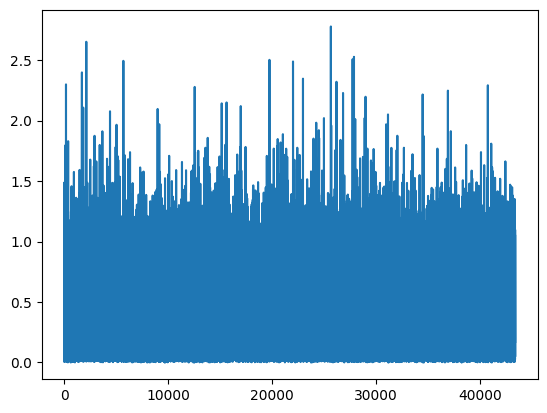

In [165]:
normal_scores.plot()

<Axes: >

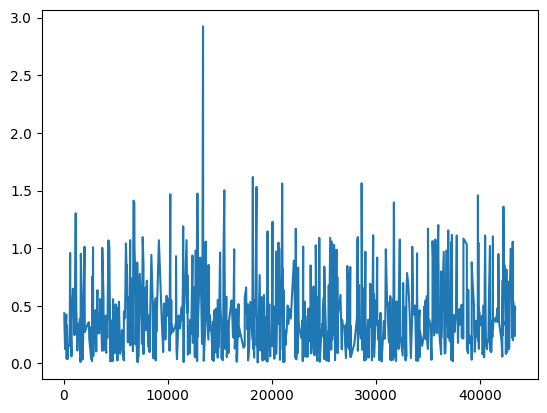

In [166]:
anomaly_scores.plot()

# TODO:
Concat values
Apply threshold and build confusion matrices

In [ ]:

pd.concat([normal_scores, anomaly_scores], ignore_index=False, sort=True)

0        0.063659
1        0.031501
2        0.420205
3        0.394662
4        1.488235
           ...   
43148    0.541584
43268    0.271196
43304    0.237504
43318    0.495011
43339    0.468795
Length: 43400, dtype: float64

In [105]:
results_df = pd.DataFrame(scores, columns=["anomaly_score"])
results_df["Y"] = y.copy()

In [112]:
results_df.groupby("Y")["anomaly_score"].describe()

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
0,42617.0,0.348330,0.333319,0.000146,0.074797,0.25639,0.520520,2.827868
1,783.0,0.408754,0.341193,0.006628,0.166636,0.33792,0.522081,2.991218


In [119]:
# Play around with the threshold
threshold = 0.5

results_df["Y_pred"] = (results_df.anomaly_score > threshold).astype(int)
results_df

,anomaly_score,Y,Y_pred
0,0.066137,0,0
1,0.032010,0,0
2,0.421733,0,0
3,0.381697,0,0
4,1.485957,0,1
...,...,...,...
43395,0.390940,0,0
43396,0.886114,0,1
43397,0.336096,0,0
43398,0.051581,0,0


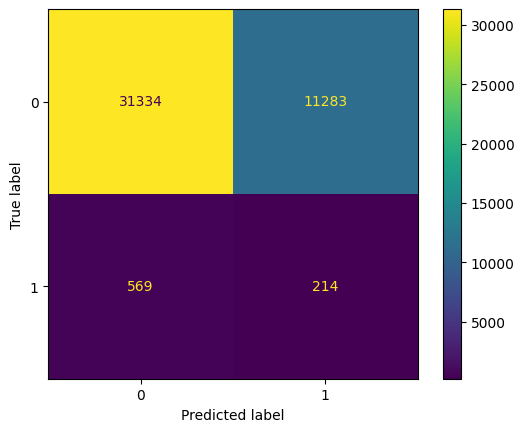

In [120]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(results_df.Y, results_df.Y_pred),
)

disp.plot()

There is a clear trade-off between the number of false positives and false negatives as we adjust the threshold to identify stroke based on the anomaly score. The results indicate that PCA may not be an adequate option for this use case.